In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, UpSampling2D, Reshape, Concatenate, Conv2DTranspose, Multiply, Add
from tensorflow.keras.applications.resnet import ResNet101
import tensorflow as tf
from tensorflow.keras.metrics import Recall, Precision, AUC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/mured.zip", 'r') as zip:
  zip.extractall()
  print("Done")

Mounted at /content/drive
Done


In [ ]:
train_data = pd.read_csv('/content/train_data_modified.csv')
train_data = train_data.sample(frac=1)[:1600]
train_data

,Unnamed: 0,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,...,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER,ID_2
16,16,aria_c_35_27,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,aria_c_35_27.tif
887,887,1103,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1103.png
20,20,aria_c_6_5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,aria_c_6_5.tif
576,576,655,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,655.png
744,744,899,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,899.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,1388,1796,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1796.png
651,651,771,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,771.png
750,750,907,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,907.png
1337,1337,1727,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1727.png


In [ ]:
test_data = pd.read_csv('/content/test_data_modified.csv')
test_data = test_data[:320]


In [ ]:
labels = ['DR', 'NORMAL','MH','ODC','TSLN','ARMD','DN','MYA','BRVO','ODP','CRVO','CNV','RS','ODE','LS','CSR','HTR','ASR','CRS','OTHER']
labels_full = ['DIABETIC RETINOPATHY', 'NORMAL','MEDIA HAZE','OPTIC DISC COLOBOMA','TESSELLATION','AGE RELATED MACULAR DEGENERATION','DRUSEN','MYOPIA','BRANCH RETINAL VEIN OCCLUSION','OPTIC DISC PALLOR','CENTRAL RETINAL VEIN OCCLUSION','CHOROIDAL NEOVASCULARIZATION','RETINITIS','OPTIC DISC EDEMA','LASER SCARS','CENTRAL SEROUS RETINOPATHY','HYPERTENSIVE RETINOPATHY','ARTIFICIAL SILICON RETINA','CHORIORETINITIS','OTHER']


In [ ]:
img_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.2,
                             rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             fill_mode = 'nearest'
                             )
# img_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)
# img_gen_test = ImageDataGenerator(rescale=1./255)
train_gen = img_gen.flow_from_dataframe(dataframe=train_data,
                                        directory="/content/images/images",
                                        x_col = "ID_2",
                                        y_col = labels,
                                        class_mode = 'raw',
                                        batch_size = 16,
                                        target_size = (320,320),
                                        subset='training')

val_gen = img_gen.flow_from_dataframe(dataframe=train_data,
                                        directory="/content/images/images",
                                        x_col = "ID_2",
                                        y_col = labels,
                                        class_mode = 'raw',
                                        batch_size =16,
                                        target_size = (320,320),
                                        subset='validation')



Found 1280 validated image filenames.
Found 320 validated image filenames.


In [ ]:
test_gen = img_gen.flow_from_dataframe(dataframe=test_data,
                                        directory="/content/images/images",
                                        x_col = "ID_2",
                                        y_col = labels,
                                        class_mode = 'raw',
                                        batch_size = 16,
                                        target_size = (320,320))

Found 320 validated image filenames.


## Feature Extraction


In [ ]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        _ (tf.keras.Model): sequential model
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
basemodel = DenseNet201(include_top = False, weights = 'imagenet', input_shape = (320,320,3)) #high level features
basemodel_l = Model(inputs = basemodel.inputs, outputs =basemodel.layers[-228].output) #lower level features


#MSFM part
f_dash_h = Conv2D(512, (1, 1))(basemodel.output)
f_l = Conv2D(512, (1, 1))(basemodel_l.output)

# Use the output tensors of the layers
f_u = Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu')(f_dash_h)
f_c = Add()([f_u, f_l])

# Additional convolutional layer using the concatenated features
f_dash_l = Conv2D(512, 3, padding='same', activation='relu')(f_c)

#CAM module
f_p = GlobalAveragePooling2D()(f_dash_l)
f_p_reshaped = Reshape((1, 1, -1))(f_p)

#1x1 conv with relu
f_v = Conv2D(512, (1,1), activation = 'relu')(f_p_reshaped)

#1x1 conv with sigmoid
f_v = Conv2D(512, (1,1), activation='sigmoid')(f_v)

#mult f_dash_1 with f_v
f_v = Multiply()([f_dash_l, f_v])

#concat f_dash_l with f_v
f_ddash_l = Add()([f_dash_l, f_v])
# Create the model
model_l = tf.keras.Model(inputs= basemodel.input, outputs=f_ddash_l)
model_h = tf.keras.Model(inputs = basemodel.input, outputs = f_dash_h )

Q = f_dash_h
K = f_ddash_l
V = f_ddash_l

tf.reshape(Q, (-1, 100, 512))
tf.reshape(K, (-1, 400, 512))
tf.reshape(V, (-1, 400, 512))

mha = tf.keras.layers.MultiHeadAttention(
    num_heads=8,
    key_dim=512,
    dropout=0.1
)

ffn = FullyConnected(
    embedding_dim=512,
    fully_connected_dim=512
)

layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

dropout_ffn = tf.keras.layers.Dropout(0.1)


"""
Forward pass for the Encoder Layer

Arguments:
    x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
    training (bool): Boolean, set to true to activate
                the training mode for dropout layers
    mask (tf.Tensor): Boolean mask to ensure that the padding is not
            treated as part of the input
Returns:
    encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
"""
# calculate self-attention using mha(~1 line).
# Dropout is added by Keras automatically if the dropout parameter is non-zero during training
self_mha_output = mha(Q, K, V)  # Self attention (batch_size, input_seq_len, fully_connected_dim)

# skip connection
# apply layer normalization on sum of the input and the attention output to get the
# output of the multi-head attention layer
skip_x_attention = layernorm1(Q + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

# pass the output of the multi-head attention layer through a ffn
ffn_output = ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)

# apply dropout layer to ffn output during training
# use `training=training`
ffn_output = dropout_ffn(ffn_output, training=True)

# apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output
# to get the output of the encoder layer
msfm_out = layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)

tf.reshape(msfm_out,(-1,100,512))

74836368/74836368 [==============================] - 3s 0us/step


<KerasTensor: shape=(None, 100, 512) dtype=float32 (created by layer 'tf.reshape_3')>

In [ ]:
basemodel.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1/conv[0][0]']

## Encoder Part

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    This architecture includes a residual connection around each of the two
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):

        # embedding_dim ---> Dimension of the input vectors (d)
        # num_heads      --> Number of attention heads in the multihead mechanism
        # fully_connected_dim --> Size of the fully  connected feed-forward network

        super(EncoderLayer, self).__init__() # super(EncoderLayer, self).__init__() is used to call the constructor of the superclass (Layer) from within the subclass (EncoderLayer). This ensures that the superclass's initialization logic is executed before any additional initialization logic defined in the subclass.

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        # # 3X3 CONVOLUTION
        # self.conv = Conv2D(512, 3 ,  padding = 'same', activation = 'relu')

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)



        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, q, k, v, training=False):
        """
        Forward pass for the Encoder Layer

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(q, k, v)  # Self attention (batch_size, input_seq_len, fully_connected_dim)

        skip_x_attention = self.layernorm1(q + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # # Reshape the output for convolutional layer
        # conv_input = tf.reshape(skip_x_attention, (-1, 11, 11, 512))
        # # Apply 3x3 Convolution Layer
        # conv_output = self.conv(conv_input)

        # # Reshape the output back to original shape
        # conv_output = tf.reshape(conv_output, (-1, 121, 512))

        # # skip connection
        # # apply layer normalization on sum of the input and the attention output to get the
        # # output of the multi-head attention layer (~1 line)

        # pass the output of the multi-head attention layer through a ffn (~1 line)'''
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)

        # apply dropout layer to ffn output during training (~1 line)
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        # END CODE HERE

        return encoder_layer_out


class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    encoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, q, k, v, training):
        """
        Forward pass for the Encoder

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
        """
        for i in range(self.num_layers):
            if i == 0:
                x = self.enc_layers[i](q, k, v, training)

            else:
                x = self.enc_layers[i](x, x, x, training)
        # END CODE HERE

        return x  # (batch_size, input_seq_len, embedding_dim)


encoder = Encoder(8, 512, 8, 512)

In [ ]:
disease_labels = ['DR', 'NORMAL','MH','ODC','TSLN','ARMD','DN','MYA','BRVO','ODP','CRVO','CNV','RS','ODE','LS','CSR','HTR','ASR','CRS','OTHER']


# 4. Tokenization and Encoding
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained BioBERT model and tokenizer
model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Encode disease labels
encoded_labels = []
for label in disease_labels:
    encoded_input = tokenizer(label, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        output = model(**encoded_input)
    pooled_output = output.pooler_output  # Extract pooled output
    encoded_labels.append(np.array(pooled_output))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:

encoded_labels = np.array(encoded_labels)
encoded_labels = np.resize(encoded_labels, (1,20,768))
encoded_labels = tf.keras.layers.Dense(512)(encoded_labels)
encoded_labels = np.broadcast_to(encoded_labels, (16, 20, 512))
# concatenated = tf.concat([msfm_out, tf.expand_dims(encoded_labels, axis=0)], axis=1)
F_cat = tf.concat([encoded_labels, tf.reshape(msfm_out, (-1, 100, 512))], 1)

In [ ]:
Encoder1 = encoder(F_cat, F_cat, F_cat)

In [ ]:
Encoder1

<KerasTensor: shape=(16, 120, 512) dtype=float32 (created by layer 'encoder')>

In [ ]:

# Pad the tensor with -infinity to increase the second dimension from 120 to 125
Encoder1_pad = tf.pad(Encoder1, [[0, 0], [0, 1], [0, 0]], constant_values= 0.0)

# print(f"Shape of the original tensor: {tensor.shape}")
print(f"Shape of the padded tensor: {Encoder1_pad.shape}")
Encoder1_pad_reshape = tf.reshape(Encoder1_pad, (-1, 11, 11, 512))
Encoder1_pad_reshape

Shape of the padded tensor: (16, 121, 512)


<KerasTensor: shape=(16, 11, 11, 512) dtype=float32 (created by layer 'tf.reshape_5')>

In [ ]:
gap = GlobalAveragePooling2D()(Encoder1_pad_reshape)
#gmp = GlobalMaxPooling2D()(x)
x = Dense(256, activation='relu')(gap)
prediction = Dense(20, activation='sigmoid')(x)

model_1 = Model(inputs = basemodel.input, outputs = prediction)
model_1.compile(optimizer=Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy', AUC()])
model_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
history = model_1.fit(train_gen, steps_per_epoch=train_gen.n // 16, epochs = 35, validation_data=val_gen, validation_steps=val_gen.n // 16)

Epoch 1/35
80/80 [==============================] - 322s 2s/step - loss: 0.2316 - accuracy: 0.2172 - auc: 0.7004 - val_loss: 0.2179 - val_accuracy: 0.2375 - val_auc: 0.7429
Epoch 2/35
80/80 [==============================] - 162s 2s/step - loss: 0.2131 - accuracy: 0.2352 - auc: 0.7390 - val_loss: 0.2091 - val_accuracy: 0.3781 - val_auc: 0.7656
Epoch 3/35
80/80 [==============================] - 155s 2s/step - loss: 0.1999 - accuracy: 0.3633 - auc: 0.7859 - val_loss: 0.2065 - val_accuracy: 0.4031 - val_auc: 0.7637
Epoch 4/35
80/80 [==============================] - 155s 2s/step - loss: 0.1943 - accuracy: 0.3828 - auc: 0.8014 - val_loss: 0.2002 - val_accuracy: 0.3781 - val_auc: 0.7857
Epoch 5/35
80/80 [==============================] - 155s 2s/step - loss: 0.1895 - accuracy: 0.3945 - auc: 0.8200 - val_loss: 0.1904 - val_accuracy: 0.4125 - val_auc: 0.8173
Epoch 6/35
80/80 [==============================] - 154s 2s/step - loss: 0.1847 - accuracy: 0.3883 - auc: 0.8327 - val_loss: 0.1852 - v

In [ ]:
model_1.evaluate(test_gen)

20/20 [==============================] - 30s 1s/step - loss: 0.1235 - accuracy: 0.6375 - auc: 0.9358


[0.12354886531829834, 0.637499988079071, 0.9358378648757935]

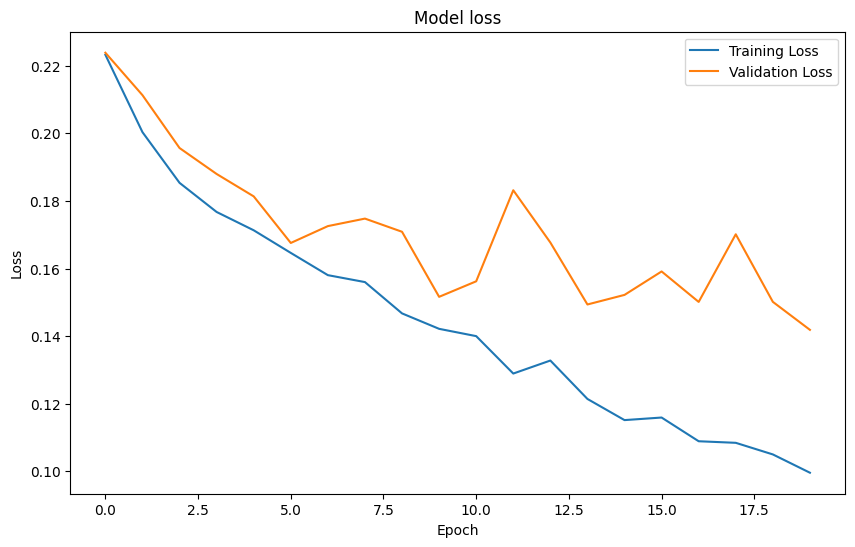

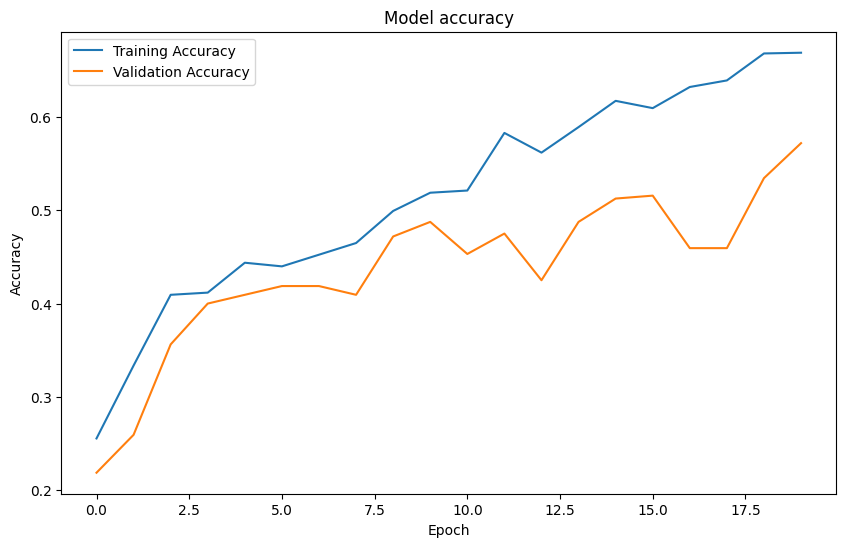

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and have access to the history object
# history = model.fit(...)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
